In [1]:
import sys
sys.path.append('/share/gpu0/jjwhit/rcGAN/')
import torch

import pytorch_lightning as pl
import numpy as np
import torch.autograd as autograd
import sigpy as sp
from matplotlib import cm

from PIL import Image
from torch.nn import functional as F
from utils.mri.fftc import ifft2c_new, fft2c_new
from mass_map_utils.scripts.transforms import tensor_to_complex_np
from models.archs.mass_map.generator import UNetModel
from models.archs.mass_map.discriminator import DiscriminatorModel
from evaluation_scripts.metrics import psnr
from torchmetrics.functional import peak_signal_noise_ratio

from data.lightning.MassMappingDataModule import MMDataTransform
from data.datasets.MM_data import MassMappingDataset_Test, MassMappingDataset_Train, MassMappingDataset_Val

/share/gpu0/jjwhit/rcGAN/fastmri/__init__.py:16: UserWarning: Could not retrieve fastmri version!
  warnings.warn("Could not retrieve fastmri version!")


In [2]:
data_dir = '/share/gpu0/jjwhit/kappa_cosmos_simulations/cropped_dataset/kappa_val/'

In [3]:
import yaml
import json
import types
import torch
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_object(dct):
    return types.SimpleNamespace(**dct)

with open('/home/jjwhit/rcGAN/configs/mass_map_test.yml', 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    cfg = json.loads(json.dumps(cfg), object_hook=load_object)

In [6]:
mm_data_transform = MMDataTransform(args=None)
mm_dataset_train = MassMappingDataset_Train(data_dir=data_dir, transform=mm_data_transform)
new_data = mm_dataset_train.__getitem__(0)
print('new_data size', new_data.shape)

# y, x, mean, std = new_data


# x = x[None,:,:,:].to(device)
# y = y[None,:,:,:].to(device)


ValueError: operands could not be broadcast together with shapes (300,300) (1024,1024) 

In [ ]:
y.size()

In [ ]:
x.size()

In [9]:
def get_noise(num_vectors, resolution=1024):
    z = torch.randn(num_vectors, 2, resolution, resolution, device=device)
    return z

num_vectors = y.size(0)
noise = get_noise(num_vectors)

input_data = torch.cat([y, noise], dim=1)


In [10]:
input_data.size()

torch.Size([1, 4, 1024, 1024])

In [12]:
resolution = 1024
def reformat(samples):
    reformatted_tensor = torch.zeros(size=(samples.size(0), 1, resolution, resolution, 2),
                                     device=device)
    reformatted_tensor[:, :, :, :, 0] = samples[:, 0, :, :]
    reformatted_tensor[:, :, :, :, 1] = samples[:, 1, :, :]

    return reformatted_tensor

In [13]:
new_tensor = reformat(input_data)

In [14]:
new_tensor.size()
#Tensor size

torch.Size([1, 1, 1024, 1024, 2])

In [15]:
def readd_measures(samples, measures, mask):
    reformatted_tensor = reformat(samples)
    measures = fft2c_new(reformat(measures))
    reconstructed_kspace = fft2c_new(reformatted_tensor)

    reconstructed_kspace = mask * measures + (1 - mask) * reconstructed_kspace

    image = ifft2c_new(reconstructed_kspace)

    output_im = torch.zeros(size=samples.shape, device=device)
    output_im[:, 0, :, :] = image[:, :, :, :, 0]
    output_im[:, 1, :, :] = image[:, :, :, :, 1]

    return output_im

In [16]:
generator = UNetModel(
    in_chans=4,
    out_chans=2,
)
generator.to(device)

UNetModel(
  (down_sample_layers): ModuleList(
    (0): ConvDownBlock(
      (conv_1): Conv2d(4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (res): ResidualBlock(
        (conv_block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): PReLU(num_parameters=1)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): PReLU(num_parameters=1)
        )
        (conv_1x1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): PReLU(num_parameters=1)
    )
    (1): ConvDownBlock(
      (c

In [17]:
def forward(y, mask):
    num_vectors = y.size(0)
    noise = get_noise(num_vectors, mask)
    samples = generator(input_data)
    samples = readd_measures(samples, y, mask)
    return samples

In [18]:
y.size()

torch.Size([1, 2, 1024, 1024])

In [19]:
noise.size()

torch.Size([1, 2, 1024, 1024])

In [20]:
forward_test = forward(y, 0)

In [28]:
torch.cuda.device_count()

1

# Test

In [1]:
import sys
sys.path.append('/home/jjwhit/rcGAN/')
import torch
import yaml
import types
import json

import pytorch_lightning as pl

from pytorch_lightning.callbacks import ModelCheckpoint
from data.lightning.MRIDataModule import MRIDataModule
from utils.parse_args import create_arg_parser
from models.lightning.rcGAN import rcGAN
from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import WandbLogger
from data.lightning.MassMappingDataModule import MMDataModule
from data.lightning.RadioDataModule import RadioDataModule
from models.lightning.mmGAN import mmGAN

/home/jjwhit/rcGAN/fastmri/__init__.py:16: UserWarning: Could not retrieve fastmri version!
  warnings.warn("Could not retrieve fastmri version!")


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
%run /home/jjwhit/rcGAN/train.py --config /home/jjwhit/rcGAN/configs/mass_map_test.yml --exp-name mmgan_debug --num-gpus 1

[rank: 0] Global seed set to 0


Experiment Name: mmgan_debug
Number of GPUs: 1
Device count:  1
Config file path: /home/jjwhit/rcGAN/configs/mass_map_test.yml


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jess-j-whitney. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[rank: 0] Global seed set to 0
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
[W socket.cpp:426] [c10d] The server socket cannot be initialized on [::]:16374 (errno: 97 - Address family not supported by protocol).
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

[W socket.cpp:601] [c10d] The client socket cannot be initialized to connect to [compute-gpu-0-3.local]:16374 (errno: 97 - Address family not supported by protocol).
[W socket.cpp:601] [c10d] The client socket cannot be initialized to connect to [compute-gpu-0-3.local]:16374 (errno: 97 - Address family not supported by protocol).
/ho

Sanity Checking: 0it [00:00, ?it/s]

/home/jjwhit/.conda/envs/cGAN/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jjwhit/rcGAN/data/lightning/MassMappingDataModule.py:99: RuntimeWarning: divide by zero encountered in true_divide
  F_kappa = F_gamma / D
/home/jjwhit/.conda/envs/cGAN/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/jjwhit/rcGAN/data/lightning/MassMappingDataModule.py:99: RuntimeWarning: divide by zero encountered in true_divide
  F_kappa = F_gamma / D


Validation: 0it [00:00, ?it/s]

/home/jjwhit/rcGAN/data/lightning/MassMappingDataModule.py:99: RuntimeWarning: divide by zero encountered in true_divide
  F_kappa = F_gamma / D
/home/jjwhit/rcGAN/data/lightning/MassMappingDataModule.py:99: RuntimeWarning: divide by zero encountered in true_divide
  F_kappa = F_gamma / D


In [ ]:
%run /share/gpu0/jjwhit/rcGAN/scripts/mass_map/validate.py --exp-name mmgan_debug

In [ ]:
%run /share/gpu0/jjwhit/rcGAN/scripts/mass_map/test.py --exp-name mmgan_debug

In [3]:
import numpy as np

Testing model with added input channel (Kaiser-Squires)

In [4]:
cosmos_path = '/home/jjwhit/rcGAN/mass_map_utils/cosmos/'
mask = np.load(cosmos_path + 'cosmos_mask.npy', allow_pickle=True)
std1 = np.load(cosmos_path + 'cosmos_std1.npy', allow_pickle=True)
std2 = np.load(cosmos_path + 'cosmos_std2.npy', allow_pickle=True)

In [5]:
test_kappa = np.load('/share/gpu0/jjwhit/kappa_cosmos_simulations/cropped_dataset/kappa_val/cropped_sim_08834.npy')

In [7]:
test_kappa.shape

(300, 300)

In [8]:
test_reshape = np.expand_dims(test_kappa, axis=-1)

In [9]:
test_reshape.shape

(300, 300, 1)

In [10]:
import matplotlib.pyplot as plt

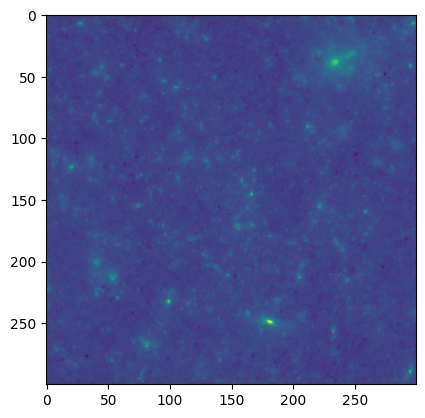

In [12]:
plt.imshow(test_reshape)

In [13]:
def compute_fourier_kernel(N: int) -> np.ndarray:
    """Computes the Fourier space kernel which represents the mapping between 
        convergence (kappa) and shear (gamma).

    Args:
        N (int): x,y dimension of image patch (assumes square images).

    Returns:
        D (np.ndarray): Fourier space Kaiser-Squires kernel, with shape = [N,N].
    """
    # Generate grid of Fourier domain
    kx = np.arange(N).astype(np.float64) - N/2
    kx, ky = np.meshgrid(kx, kx)
    k = kx**2 + ky**2
    # Define Kaiser-Squires kernel
    D = np.zeros((N, N), dtype=np.complex128)
    # Avoid divide by zero warning
    D[k>0] = (((kx ** 2.0 - ky ** 2.0) + 1j * (2.0 * kx * ky))[k>0]/k[k>0])
    # Apply inverse FFT shift 
    return np.fft.ifftshift(D)

In [21]:
compute_fourier_kernel(300).shape

(300, 300)

In [22]:
F_kappa = np.fft.fft2(test_kappa)
F_gamma = F_kappa * compute_fourier_kernel(300)

In [23]:
test_gamma = np.fft.ifft2(F_gamma)

In [24]:
test_gamma.shape

(300, 300)

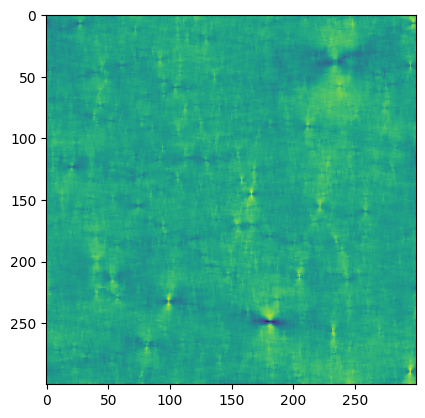

In [25]:
plt.imshow(test_gamma.real)